Deep Learning with Tensorflow
=============
 Lab Exercise 1
 ----


The objective of this lab is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later. In addtion, we are going to build a simple Logistic Regresison model, evaluate its performance and visualize its weights. At the end, we will be touching some Tensorflow Basics.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image, clear_output
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf

In [2]:
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
onlyfiles = [f for f in os.listdir(train_folders[0]) if os.path.isfile(os.path.join(train_folders[0], f))]
clear_output(wait=True)
num_selected_samples = 3

for (label, cl) in enumerate(train_folders): 
    list_of_random_items = random.sample([os.path.join(cl, f) 
                                          for f in os.listdir(cl) 
                                          if os.path.isfile(os.path.join(cl, f))], 
                                         num_selected_samples)
    print("Class %s" % chr(65 + label));
    Image(filename="./notMNIST_large/A/R2VvbWV0cjIzMSBIdiBCVCBIZWF2eS50dGY=.png")
    for it in list_of_random_items:
        display(Image(filename=it))

Class A


Class B


Class C


Class D


Class E


Class F


Class G


Class H


Class I


Class J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you have to use pickle and matplotlib.pyplot, also take a look at matplotlib.cm

---

./notMNIST_large/A.pickle


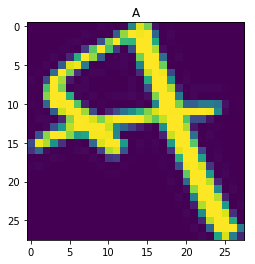

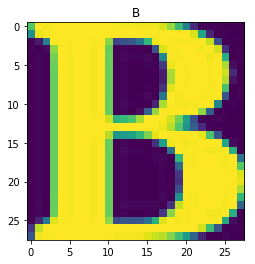

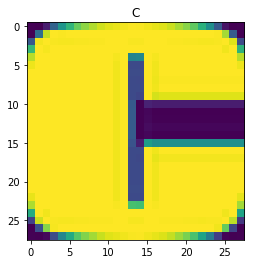

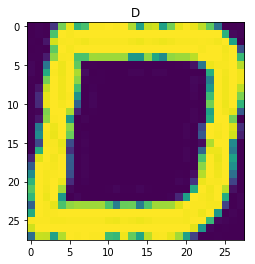

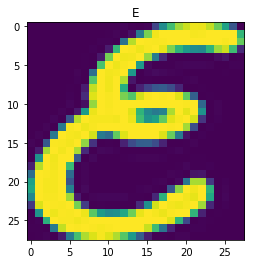

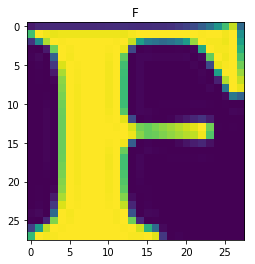

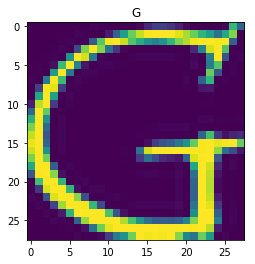

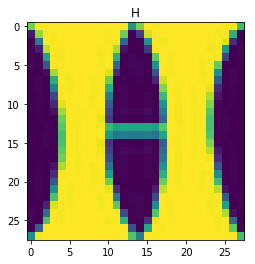

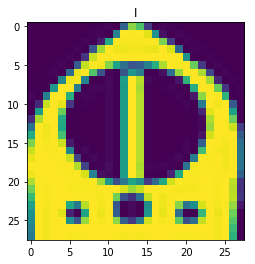

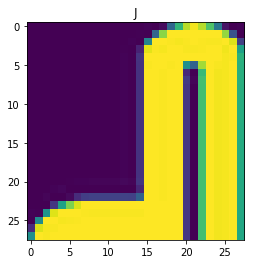

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


In [7]:
print(train_datasets[0])

for label, pickle_file in enumerate(train_datasets):
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
    random_idx = random.randint(0, len(letter_set))
    plt.imshow(letter_set[random_idx])
    plt.title(chr(65+label))
    plt.show()
    
print(train_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that
---

In [8]:
for label, pickle_file in enumerate(train_datasets):
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)
    print("For label %c there are %d images" % (chr(65+label), len(dataset)))

For label A there are 52909 images
For label B there are 52911 images
For label C there are 52912 images
For label D there are 52911 images
For label E there are 52912 images
For label F there are 52912 images
For label G there are 52912 images
For label H there are 52912 images
For label I there are 52912 images
For label J there are 52911 images


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Train set: 


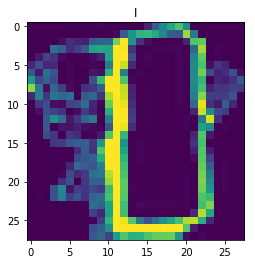

Validation set: 


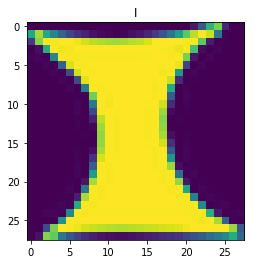

Test set: 


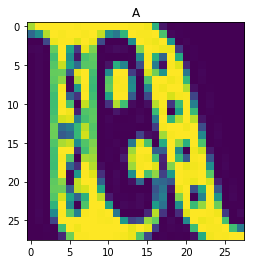

In [11]:
# 1 random example from train/val/test sets

rand_train_inx = random.randint(0, len(train_dataset))
rand_val_inx = random.randint(0, len(valid_dataset))
rand_test_inx = random.randint(0, len(test_dataset))

print("Train set: ")
plt.imshow(train_dataset[rand_train_inx])
plt.title(chr(65+train_labels[rand_train_inx]))
plt.show()

print("Validation set: ")
plt.imshow(valid_dataset[rand_val_inx])
plt.title(chr(65+valid_labels[rand_val_inx]))
plt.show()

print("Test set: ")
plt.imshow(test_dataset[rand_test_inx])
plt.title(chr(65+test_labels[rand_test_inx]))
plt.show()


Finally, let's save the data for later reuse:

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent labs.
---

In [14]:
import time

# same points should hash to the same bucket
def check_overlaps(images1, images2):
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

def check_duplicates(images):
    duplicates = 0
    dup_table = {}
    for idx, data in enumerate(images):
        hsh = hash(data.tobytes())
        
        if hsh in dup_table: 
            duplicates = duplicates + 1
        else:
            dup_table[hsh] = idx
            
    sanitized = []
    
    for (hsh, idx) in dup_table.items():
        sanitized.append(images[idx])
            
    return duplicates, sanitized     

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: %d. Execution time: %.3f.' % (len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: %d. Execution time: %.3f.' % (len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: %d. Execution time: %.3f.' % (len(r), execTime))



Number of overlaps between training and test sets: 1111. Execution time: 0.478.
Number of overlaps between training and validation sets: 976. Execution time: 0.463.
Number of overlaps between validation and test sets: 50. Execution time: 0.044.


In [15]:
# Make sanitized datasets here TODO

def sanitize(images1, images2, images3):
    img1_table = {}
    img2_table = {}
    img3_table = {}
    
    for idx, data in enumerate(images1):
        hsh = hash(data.tobytes())
        
        if hsh not in img1_table: 
            img1_table[hsh] = idx
    
    for idx, data in enumerate(images2):
        hsh = hash(data.tobytes())
        
        if hsh not in img2_table: 
            img2_table[hsh] = idx
    
    for idx, data in enumerate(images3):
        hsh = hash(data.tobytes())
        
        if hsh not in img3_table: 
            img3_table[hsh] = idx
    
            
    sanitized = []
    
    for (hsh, idx) in img1_table.items():
        if hsh not in img2_table and hsh not in img3_table: 
            sanitized.append(images1[idx])
            
    return sanitized

dup_train, sanitized_train_set = check_duplicates(train_dataset)
dup_val, sanitized_valid_set = check_duplicates(valid_dataset)
dup_test, sanitized_test_set = check_duplicates(test_dataset)

print("Number of duplicate images in train dataset: %d " % dup_train)
print("Number of duplicate images in validation dataset: %d " % dup_val)
print("Number of duplicate images in test dataset: %d " % dup_test)

san_train = sanitize(sanitized_train_set, sanitized_valid_set, sanitized_test_set)
san_val = sanitize(sanitized_valid_set, sanitized_train_set, sanitized_test_set)
san_test = sanitize(sanitized_test_set, sanitized_train_set, sanitized_valid_set)

print()
print("Size of test set before sanitization: %d " % len(train_dataset))
print("Size of validation set before sanitization: %d " % len(valid_dataset))
print("Size of train set before sanitization: %d " % len(test_dataset))

print()
print("Size of test set after sanitization: %d " % len(san_train))
print("Size of validation set after sanitization: %d " % len(san_val))
print("Size of train set after sanitization: %d " % len(san_test))


Number of duplicate images in train dataset: 12544 
Number of duplicate images in validation dataset: 126 
Number of duplicate images in test dataset: 206 

Size of test set before sanitization: 200000 
Size of validation set before sanitization: 10000 
Size of train set before sanitization: 10000 

Size of test set after sanitization: 185383 
Size of validation set after sanitization: 8862 
Size of train set after sanitization: 8647 


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

The code below trains a LogisticRegression classifier from sklearn.linear_model on 50, 100, 1000 and 5000 training samples. Evaluate the performance of each created model instance on the test set and create a plot to visualize it. 
Hit: you can use plt.plot or plt.bar

Optional question: train an off-the-shelf model on all the data!

---

Finished training for 50 samples 
Finished training for 100 samples 
Finished training for 1000 samples 
Finished training for 1500 samples 


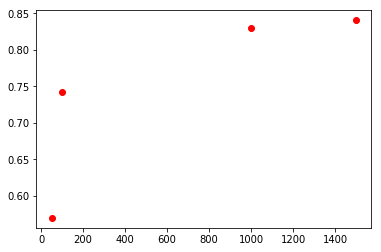

In [16]:
NUM_TRAINING_SAMPLES = [50, 100, 1000, 1500]
models = []
for num_training_samples in NUM_TRAINING_SAMPLES:
    model = LogisticRegression(
        max_iter=1000, solver='liblinear', multi_class='auto', penalty='l2'
    )
    model = model.fit(
        [sample.reshape(-1) for sample in train_dataset[:num_training_samples]],
        train_labels[:num_training_samples]
    )
    models.append(model)
    print("Finished training for %d samples " % num_training_samples)

test_dataset = np.reshape(test_dataset, (len(test_dataset), 28 * 28))

accuracies = []
for model in models:
    predictions = model.predict(test_dataset)
    accuracy = np.mean(predictions == test_labels)
    
    accuracies.append(accuracy)
    
#model = LogisticRegression(
#        max_iter=1000, solver='liblinear', multi_class='auto', penalty='l2'
#)
#model = model.fit(np.reshape(train_dataset, (len(train_dataset), 28 * 28)), train_labels)
#models.append(model)

#predictions = model.predict(test_dataset)
#accuracies.append(np.mean(predictions == test_labels))

plt.plot(NUM_TRAINING_SAMPLES, accuracies, 'ro')
plt.show()


Problem 7
---------

Visualize the coefficients of the LogisticRegression model trained with 5000 samples or more. Then train the above code with 'l1' penalty and visualize them again. Did something change?

---


[[-0.5222166  -0.58601706 -0.27010988 ...  0.67752144  0.67636953
   0.65757651]
 [ 0.39744505  0.43525151  0.30967008 ... -0.31495501 -0.03596318
   0.26898364]
 [ 0.15925227  0.22783609  0.2433903  ...  0.1708585   0.67701039
   1.03812768]
 ...
 [-0.15456121  0.08748212  0.19112958 ...  0.13840081  0.38461783
   0.41647317]
 [ 0.29040331 -0.09074767  0.42208665 ... -0.01456561  0.25008336
   0.34744194]
 [ 0.11922635 -0.09127453 -0.28470232 ... -0.36868221 -0.28050564
   0.02651042]]
(10, 784)


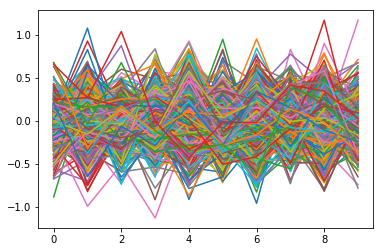

In [17]:
print(models[3].coef_)
print(models[3].coef_.shape)
plt.plot(models[3].coef_)
plt.show()

Finished training for 50 samples 
Finished training for 100 samples 
Finished training for 1000 samples 
Finished training for 1500 samples 


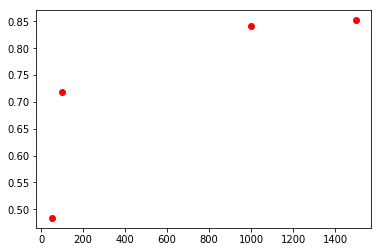

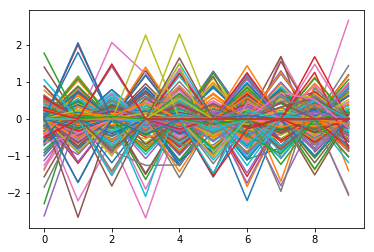

In [18]:
NUM_TRAINING_SAMPLES = [50, 100, 1000, 1500]
models1 = []
for num_training_samples in NUM_TRAINING_SAMPLES:
    model = LogisticRegression(
        max_iter=1000, solver='liblinear', multi_class='auto', penalty='l1'
    )
    model = model.fit(
        [sample.reshape(-1) for sample in train_dataset[:num_training_samples]],
        train_labels[:num_training_samples]
    )
    models1.append(model)
    print("Finished training for %d samples " % num_training_samples)

test_dataset = np.reshape(test_dataset, (len(test_dataset), 28 * 28))

accuracies = []
for model in models1:
    predictions = model.predict(test_dataset)
    accuracy = np.mean(predictions == test_labels)
    
    accuracies.append(accuracy)

plt.plot(NUM_TRAINING_SAMPLES, accuracies, 'ro')
plt.show()

plt.plot(models1[3].coef_)
plt.show()

# Now Let's get started with Tensorflow
We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

---

First reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [19]:
image_size = 28
num_labels = 10

# labels set will be transformed from 200k, to 200k, 10 as per 1-hot encoding vector has 10 values (9 0s and 1 1s)
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

new_train_dataset, new_train_labels = reformat(train_dataset, train_labels)
new_valid_dataset, new_valid_labels = reformat(valid_dataset, valid_labels)
new_test_dataset, new_test_labels = reformat(test_dataset, test_labels)
print('Training set', new_train_dataset.shape, new_train_labels.shape)
print('Validation set', new_valid_dataset.shape, new_valid_labels.shape)
print('Test set', new_test_dataset.shape, new_test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Now let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [20]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(new_train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(new_train_labels[:train_subset])
    tf_valid_dataset = tf.constant(new_valid_dataset)
    tf_test_dataset = tf.constant(new_test_dataset)
    
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:
Colocations handled automatically by placer.


Let's run this computation and iterate:

In [21]:
num_steps = 801
k = 1

def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, new_train_labels[:train_subset, :]))
            
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), new_valid_labels))
            print(valid_prediction.shape)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), new_test_labels))

Initialized
Loss at step 0: 20.143015
Training accuracy: 12.1%
Validation accuracy: 13.4%
(10000, 10)
Loss at step 100: 2.270222
Training accuracy: 71.5%
Validation accuracy: 72.0%
(10000, 10)
Loss at step 200: 1.847516
Training accuracy: 74.4%
Validation accuracy: 74.4%
(10000, 10)
Loss at step 300: 1.608826
Training accuracy: 75.5%
Validation accuracy: 75.3%
(10000, 10)
Loss at step 400: 1.443756
Training accuracy: 76.4%
Validation accuracy: 75.5%
(10000, 10)
Loss at step 500: 1.319873
Training accuracy: 77.1%
Validation accuracy: 75.7%
(10000, 10)
Loss at step 600: 1.222039
Training accuracy: 77.8%
Validation accuracy: 76.1%
(10000, 10)
Loss at step 700: 1.142257
Training accuracy: 78.3%
Validation accuracy: 76.2%
(10000, 10)
Loss at step 800: 1.075872
Training accuracy: 78.9%
Validation accuracy: 76.4%
(10000, 10)
Test accuracy: 83.1%


et's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [22]:
batch_size = 64

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(new_valid_dataset)
    tf_test_dataset = tf.constant(new_test_dataset)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
      # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
num_steps = 12000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (new_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = new_train_dataset[offset:(offset + batch_size), :]
        batch_labels = np.reshape(new_train_labels[offset:(offset + batch_size), :], (batch_size, -1))
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), new_valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), new_test_labels))

Initialized
Minibatch loss at step 0: 18.601231
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.925680
Minibatch accuracy: 84.4%
Validation accuracy: 75.9%
Minibatch loss at step 1000: 1.361071
Minibatch accuracy: 78.1%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 1.380432
Minibatch accuracy: 71.9%
Validation accuracy: 77.8%
Minibatch loss at step 2000: 1.046457
Minibatch accuracy: 78.1%
Validation accuracy: 78.0%
Minibatch loss at step 2500: 1.062013
Minibatch accuracy: 71.9%
Validation accuracy: 77.5%
Minibatch loss at step 3000: 1.011398
Minibatch accuracy: 73.4%
Validation accuracy: 78.8%
Minibatch loss at step 3500: 0.582193
Minibatch accuracy: 89.1%
Validation accuracy: 78.5%
Minibatch loss at step 4000: 1.305098
Minibatch accuracy: 70.3%
Validation accuracy: 78.7%
Minibatch loss at step 4500: 0.756989
Minibatch accuracy: 79.7%
Validation accuracy: 79.4%
Minibatch loss at step 5000: 1.085574
Minibatch accuracy: 71.9%
Validation accurac

---
Problem 8
-------

Play a bit with num_steps and batch_size of SGD. What maximum test accuracy can you achieve?
Around 88% for 12k num_steps and batch_size 64
---

---
Problem 9
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [24]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

def multilayer_perceptron(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # layer_1 = tf.nn.dropout(layer_1, 0.8) # will test with that later
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

train_subset = 10000
training_epochs = 5000
display_step = 1000
batch_size = 64

n_hidden_1 = 1024
n_input = new_train_dataset.shape[1]
n_classes = new_train_labels.shape[1]

print("%d %d %d" % (n_hidden_1, n_input, n_classes));

graph = tf.Graph()
with graph.as_default():
    
    weights = {
         'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
         'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
    }

    biases = {
         'b1': tf.Variable(tf.zeros([n_hidden_1])),
         'out': tf.Variable(tf.zeros([n_classes]))     
    }
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(new_valid_dataset)
    tf_test_dataset = tf.constant(new_test_dataset)
    
    # keep_prob = tf.placeholder("float")

    logits = multilayer_perceptron(tf_train_dataset, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    # print(tf.trainable_variables())
    #optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))

1024 784 10


In [25]:
num_steps = 24000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (new_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = new_train_dataset[offset:(offset + batch_size), :]
        batch_labels = np.reshape(new_train_labels[offset:(offset + batch_size), :], (batch_size, -1))
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        #print(batch_data.shape)
        #print(batch_labels.shape)
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, logits], feed_dict=feed_dict)
        if (step % display_step == 0):
            print(step)
            print("Minibatch loss at step %d: %f" % (step, l))
            # print(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), new_valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), new_test_labels))

Initialized
0
Minibatch loss at step 0: 480.031036
Minibatch accuracy: 4.7%
Validation accuracy: 24.9%
1000
Minibatch loss at step 1000: 39.805260
Minibatch accuracy: 76.6%
Validation accuracy: 76.5%
2000
Minibatch loss at step 2000: 9.056892
Minibatch accuracy: 79.7%
Validation accuracy: 78.6%
3000
Minibatch loss at step 3000: 2.207046
Minibatch accuracy: 78.1%
Validation accuracy: 80.0%
4000
Minibatch loss at step 4000: 3.573079
Minibatch accuracy: 79.7%
Validation accuracy: 80.2%
5000
Minibatch loss at step 5000: 2.010207
Minibatch accuracy: 78.1%
Validation accuracy: 81.7%
6000
Minibatch loss at step 6000: 2.462965
Minibatch accuracy: 85.9%
Validation accuracy: 80.9%
7000
Minibatch loss at step 7000: 0.308745
Minibatch accuracy: 87.5%
Validation accuracy: 82.0%
8000
Minibatch loss at step 8000: 0.750234
Minibatch accuracy: 84.4%
Validation accuracy: 82.1%
9000
Minibatch loss at step 9000: 1.107340
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
10000
Minibatch loss at step 100